<a href="https://colab.research.google.com/github/IsaD01/Deep-learning-/blob/Henry/Opdracht3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import os
import cv2
import requests
import pandas as pd
import numpy as np
from collections import Counter
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
from PIL import Image
from io import BytesIO
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Met behulp van requests de json data uit de huggingface gekregen. Door elk key te bekijken bevat 'rows' de data. Dit zit in een list en daarin heb je 'row', waarin de 'text' en 'image' in zit. 'text' bevat alleen 1 tekst per row en 'image' bevat 'src', 'height' en 'width'.

In [3]:
r = requests.get("https://datasets-server.huggingface.co/rows?dataset=tomytjandra%2Fh-and-m-fashion-caption-12k&config=default&split=train&offset=0&length=100")
r.json().keys()

dict_keys(['features', 'rows', 'num_rows_total', 'num_rows_per_page', 'partial'])

In [4]:
r.json()['rows'][1]['row']

{'text': 'melange dark grey trousers in sweatshirt fabric with an elasticated drawstring waist side pockets a back pocket and ribbed hems soft brushed inside',
 'image': {'src': 'https://datasets-server.huggingface.co/cached-assets/tomytjandra/h-and-m-fashion-caption-12k/--/d04b93f5405ccc14e898556b11ee2ee8b8f677ed/--/default/train/1/image/image.jpg?Expires=1716638000&Signature=omNpzE08QN81LyzT9kMPaYp3Zh97TJ-amJPIwqw2kyzPmbup-qtXt5s3147wDmtExKoYviWWVkTGIJFOThLJ-~zKpJHAk2fZd3WCbVKWY~rWj08L1RUb0qQdNTlt9ojdcWxr7moisUKD6a4H0qsyZmGWTQbslk7jcnVj36KgbuffZDcXjQ~6KTFvdkAtLiPjiHhymWQVGrZOkKq19FY2cEXUzahbG2fcWVrgurBkJIl8JI8GV06BXnyvLiQfD5UkwEO8~WvTSyjbCmR1NmEvT7wIt1udHrLhVF7YLDojCnXrrmu-lTdeSFW5X~P~wALd0arVUiGrWKJbmDEk9tkQLQ__&Key-Pair-Id=K3EI6M078Z3AC3',
  'height': 1750,
  'width': 772}}

In [5]:
texts = []
images_details = []
for i in range(len(r.json()['rows'])):
  texts.append(r.json()['rows'][i]['row']['text'])
  images_details.append(r.json()['rows'][i]['row']['image'])

df_texts = pd.DataFrame(texts, columns=['text'])
df_images = pd.DataFrame(images_details)
dataframe = pd.concat([df_texts, df_images], axis=1)

In [6]:
dataframe

,text,src,height,width
0,solid dark blue fitted top in soft stretch jer...,https://datasets-server.huggingface.co/cached-...,1750,1531
1,melange dark grey trousers in sweatshirt fabri...,https://datasets-server.huggingface.co/cached-...,1750,772
2,solid black leggings in soft jersey with a wid...,https://datasets-server.huggingface.co/cached-...,1750,1166
3,solid black short padded jacket with a jersey-...,https://datasets-server.huggingface.co/cached-...,1750,1166
4,solid black harem trousers in jersey with elas...,https://datasets-server.huggingface.co/cached-...,1750,1166
...,...,...,...,...
95,solid black joggers in sweatshirt fabric with ...,https://datasets-server.huggingface.co/cached-...,1750,1166
96,all over pattern light orange long-sleeved nur...,https://datasets-server.huggingface.co/cached-...,1750,1166
97,solid black joggers in lightweight sweatshirt ...,https://datasets-server.huggingface.co/cached-...,1750,1166
98,all over pattern other sleeveless dress in a c...,https://datasets-server.huggingface.co/cached-...,1750,1166


In [7]:
display(dataframe.info(), dataframe.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    100 non-null    object
 1   src     100 non-null    object
 2   height  100 non-null    int64 
 3   width   100 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 3.2+ KB


None

,height,width
count,100.000000,100.000000
mean,1749.980000,1227.550000
std,0.140705,251.076244
min,1749.000000,535.000000
25%,1750.000000,1166.000000
50%,1750.000000,1166.000000
75%,1750.000000,1326.750000
max,1750.000000,2173.000000


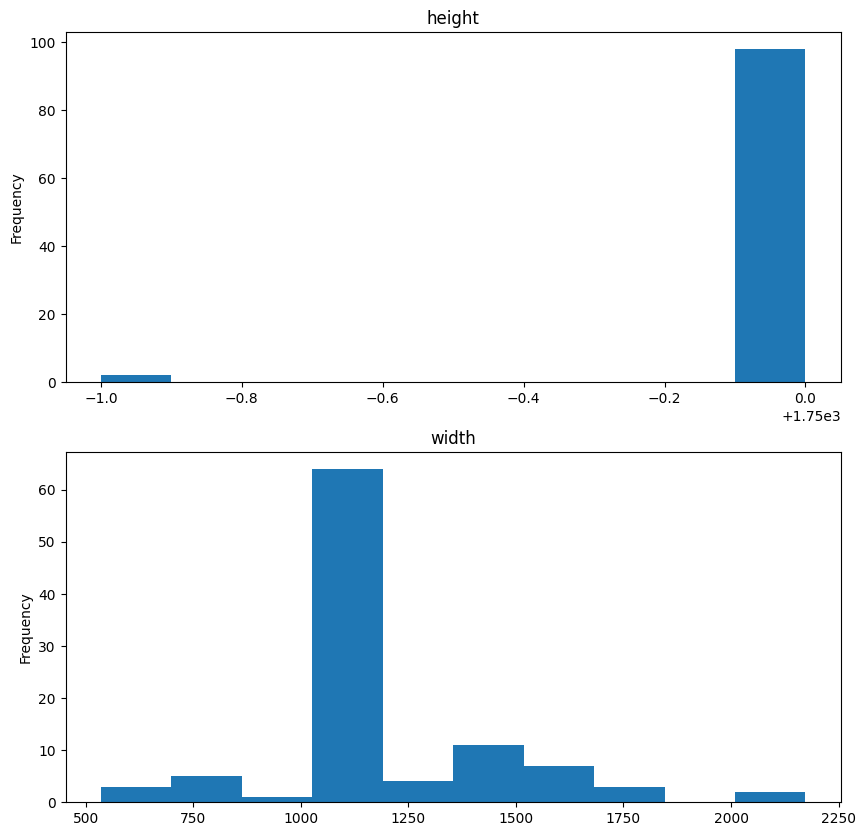

In [8]:
# Distribution of heights and widths
fig, axes = plt.subplots(2, figsize=(10,10))
axes[0].xaxis.set_major_formatter(ScalarFormatter())
axes[1].xaxis.set_major_formatter(ScalarFormatter())
dataframe['height'].plot(kind='hist', ax=axes[0], title='height')
dataframe['width'].plot(kind='hist', ax=axes[1], title='width')
plt.show()

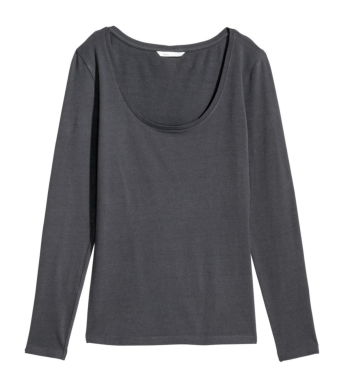

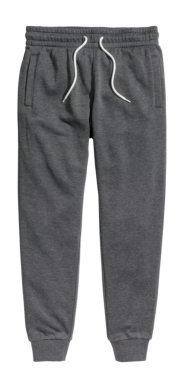

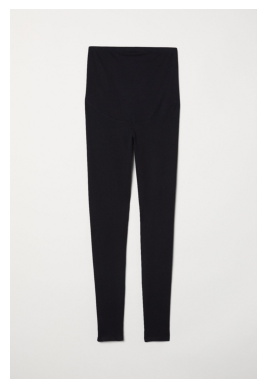

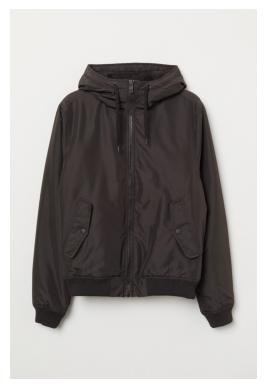

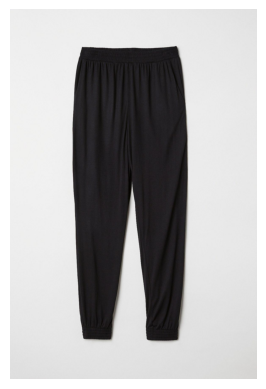

In [9]:
# Check if the images are RGB
for url in dataframe['src'][:5]:
  r = requests.get(url)
  img = Image.open(BytesIO(r.content))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

In [10]:
def clean_and_tokenize(caption):
    # Convert to lowercase
    caption = caption.lower()
    # Remove punctuation
    caption = re.sub(r'[^\w\s]', '', caption)
    # Tokenize (split into words)
    words = caption.split()
    return words

In [11]:
dataframe['text_length'] = [len(text) for text in dataframe['text']]
dataframe['tokens'] = dataframe['text'].apply(clean_and_tokenize)
dataframe['count_tokens'] = [len(tokens) for tokens in dataframe['tokens']]

In [12]:
# top words excluded stopwords
stop_words = set(stopwords.words('english'))

all_tokens = [word for tokens in dataframe['tokens'] for word in tokens]
all_tokens = [word for word in all_tokens if word not in stop_words]
top_25 = Counter(all_tokens).most_common(25)
print(top_25)

[('solid', 63), ('pockets', 49), ('black', 47), ('waist', 39), ('top', 35), ('jersey', 35), ('soft', 29), ('side', 29), ('back', 29), ('front', 27), ('denim', 27), ('cotton', 26), ('washed', 23), ('hem', 22), ('legs', 22), ('sleeves', 21), ('stretch', 19), ('elasticated', 19), ('pocket', 19), ('ribbing', 19), ('cuffs', 19), ('blue', 18), ('drawstring', 18), ('fabric', 17), ('dark', 16)]


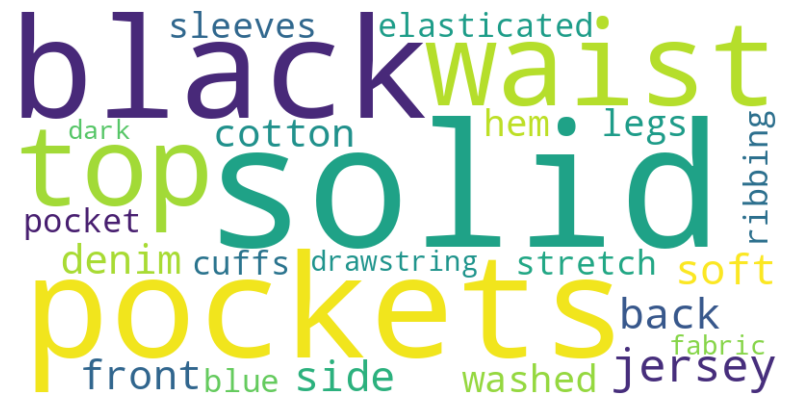

In [13]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(top_25))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [14]:
unique_words = set(all_tokens)
vocabulary_size = len(unique_words)
print(vocabulary_size)

272


In [15]:
def clean_caption(caption):
    # Convert to lowercase
    caption = caption.lower()
    # Remove special characters except spaces
    caption = re.sub(r'[^a-zA-Z0-9\s]', '', caption)
    # Remove extra whitespaces
    caption = re.sub(r'\s+', ' ', caption).strip()
    return caption

dataframe['cleaned_text'] = dataframe['text'].apply(clean_caption)

In [16]:
dataframe['cleaned_text_length'] = [len(text) for text in dataframe['cleaned_text']]
dataframe['cleaned_tokens'] = dataframe['cleaned_text'].apply(clean_and_tokenize)
dataframe['cleaned_count_tokens'] = [len(tokens) for tokens in dataframe['cleaned_tokens']]

In [17]:
dataframe['diff_text_length'] = dataframe['text_length'] - dataframe['cleaned_text_length']
dataframe['diff_count_tokens'] = dataframe['count_tokens'] - dataframe['cleaned_count_tokens']

In [18]:
dataframe.describe()

,height,width,text_length,count_tokens,cleaned_text_length,cleaned_count_tokens,diff_text_length,diff_count_tokens
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0
mean,1749.980000,1227.550000,129.900000,22.400000,128.920000,22.400000,0.980000,0.0
std,0.140705,251.076244,37.428855,6.663636,37.334058,6.663636,1.044272,0.0
min,1749.000000,535.000000,71.000000,13.000000,71.000000,13.000000,0.000000,0.0
25%,1750.000000,1166.000000,101.250000,17.000000,100.500000,17.000000,0.000000,0.0
50%,1750.000000,1166.000000,123.500000,21.500000,123.000000,21.500000,1.000000,0.0
75%,1750.000000,1326.750000,151.250000,26.000000,149.250000,26.000000,2.000000,0.0
max,1750.000000,2173.000000,235.000000,40.000000,233.000000,40.000000,5.000000,0.0


https://chatgpt.com/share/612bf8e2-1eec-4402-b332-2ebb0da2154c

In [24]:
# https://chatgpt.com/share/ae24adc4-f7a9-4ca4-9519-066c91814b25

# Define the directory to save images
image_dir = 'images'
cap_dir = 'captions'
os.makedirs(image_dir, exist_ok=True)
os.makedirs(cap_dir, exist_ok=True)

# Function to download an image
def download_image(url, save_path):
    try:
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(save_path, 'wb') as f:
                for chunk in response.iter_content(1024):
                    f.write(chunk)
        else:
            print(f"Failed to download {url}")
    except Exception as e:
        print(f"Error downloading {url}: {e}")

# Function to save a caption
def save_caption(caption, save_path):
    try:
        with open(save_path, 'w') as f:
            f.write(caption)
    except Exception as e:
        print(f"Error saving caption: {e}")

# Download each image
for idx, row in tqdm(dataframe[['text','src']].iterrows(), total=dataframe[['text','src']].shape[0]):
    url = row['src']
    cap = row['text']
    image_path = os.path.join(image_dir, f'image_{idx}.jpg')
    caption_path = os.path.join(cap_dir, f'caption_{idx}.txt')

    download_image(url, image_path)
    save_caption(cap, caption_path)

print("Download completed!")


100%|██████████| 100/100 [00:23<00:00,  4.30it/s]

Download completed!


In [25]:
IMAGE_PATH = image_dir

IMAGE_HEIGHT = 1750
IMAGE_WIDTH = 1166
IMAGE_SIZE = (IMAGE_HEIGHT,IMAGE_WIDTH)

CAPTION_PATH = cap_dir

VOCAB_SIZE = vocabulary_size

SEQ_LENGTH = 25

EMBED_DIM = 512

FF_DIM = 512

BATCH_SIZE = 64
EPOCHS = 25
AUTOTUNE = tf.data.AUTOTUNE